In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
f = h5py.File("NeutrinoML_Open_WithWire_ts331712.h5", "r")

In [3]:
print("\nprinting top-level keys:")
print(f)
print(f.keys())


printing top-level keys:
<HDF5 file "NeutrinoML_Open_WithWire_ts331712.h5" (mode r)>
<KeysViewHDF5 ['edep_table', 'event_table', 'hit_table', 'opflash_table', 'ophit_table', 'pandoraHit_table', 'pandoraPfp_table', 'pandoraPrimary_table', 'particle_table', 'wire_table']>


In [4]:
print("\nprinting keys in wire table:")
print(f["wire_table"])
print(f["wire_table"].keys())


printing keys in wire table:
<HDF5 group "/wire_table" (5 members)>
<KeysViewHDF5 ['adc', 'event_id', 'local_plane', 'local_wire', 'tpc']>


In [5]:
print("\nnow i can pull out a single entry in the event table:")
evts = f["event_table/event_id"]
evt = evts[0]
print(evt)


now i can pull out a single entry in the event table:
[6506  128 6401]


In [6]:
print("\nand i can pull out wire info for this event specifically:")
wires = f["wire_table"]
wire_idx = np.where((wires["event_id"][()] == evt).all(axis=1))
print(wire_idx)


and i can pull out wire info for this event specifically:
(array([   0,    1,    2, ..., 8253, 8254, 8255]),)


number of plane 0 wires= 2400
number of plane 1 wires= 2400
number of plane 2 wires= 3456
number of ADC reads= 6400
plane2 aspect ratio =  1.44
Run / Sub / Event : 6506 / 128 / 6401 - saturation set to ADC=15.00


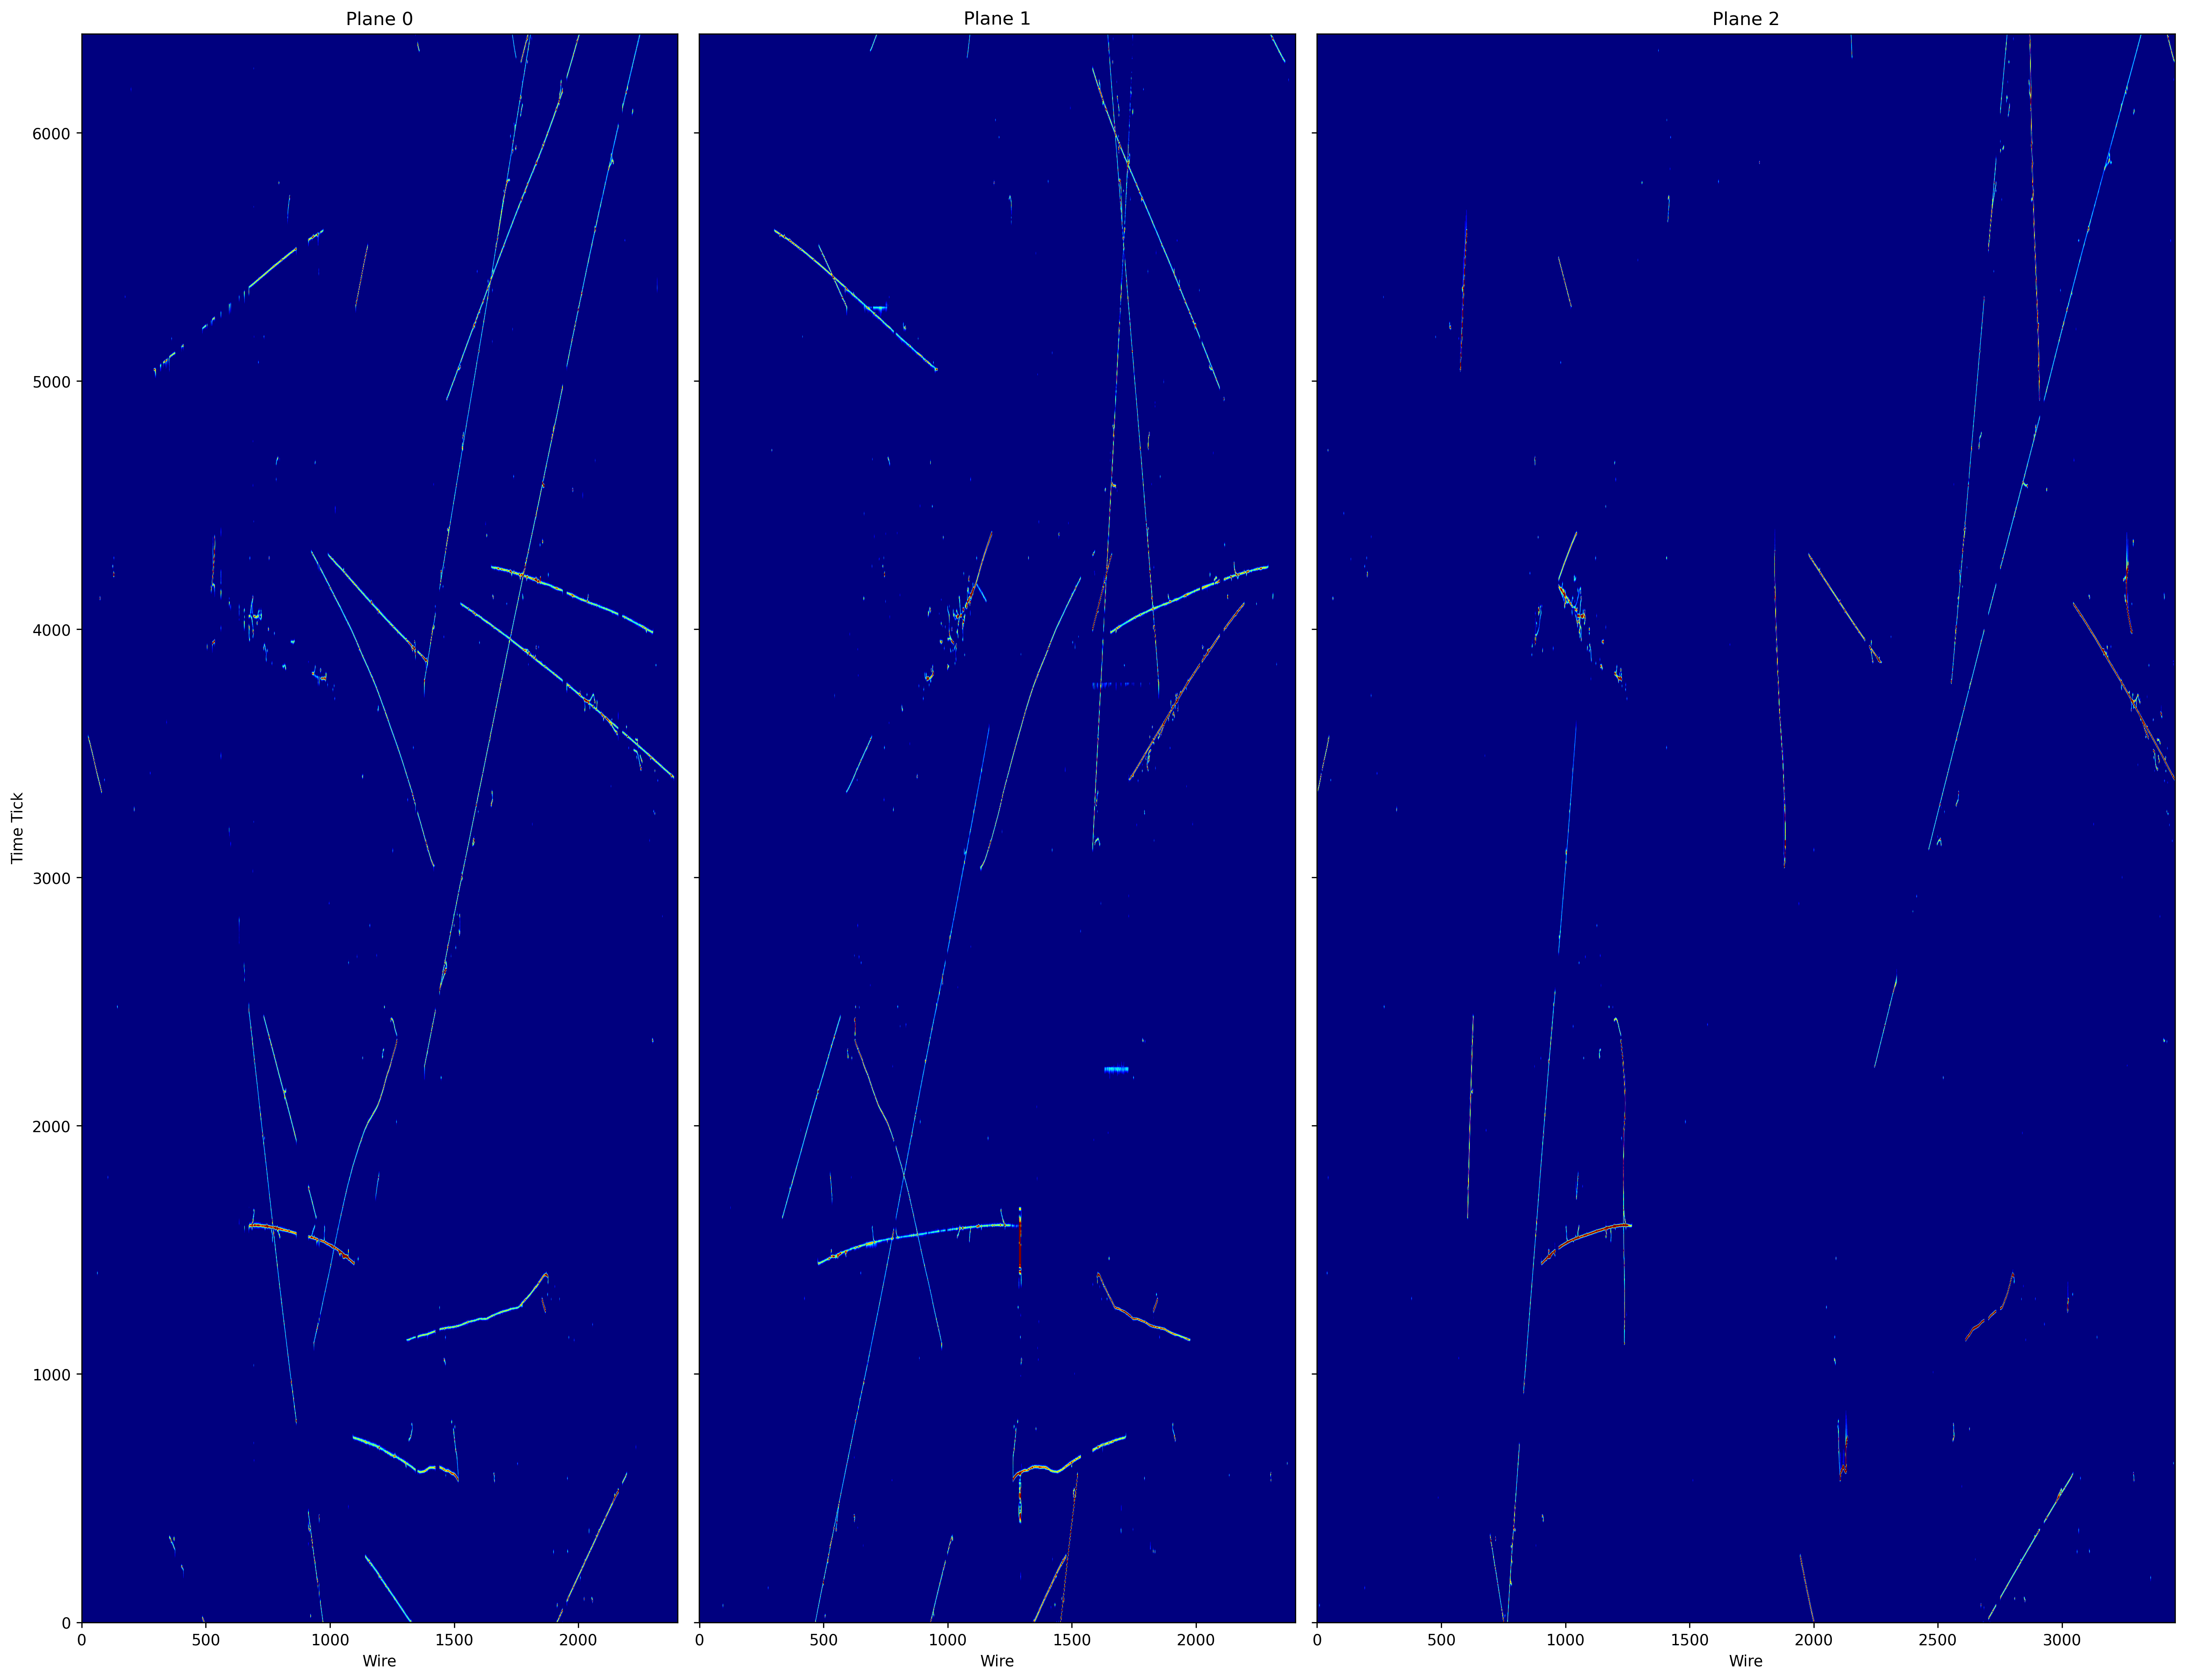

In [7]:
wire_p0_idx = np.where((wires["local_plane"][wire_idx[0]] == 0).all(axis=1))
wire_p1_idx = np.where((wires["local_plane"][wire_idx[0]] == 1).all(axis=1))
wire_p2_idx = np.where((wires["local_plane"][wire_idx[0]] == 2).all(axis=1))

print("number of plane 0 wires=",len(wire_p0_idx[0]))
print("number of plane 1 wires=",len(wire_p1_idx[0]))
print("number of plane 2 wires=",len(wire_p2_idx[0]))
print("number of ADC reads=",len(wires["adc"][wire_p2_idx[0]][0]))
print("plane2 aspect ratio = ",len(wire_p2_idx[0])/len(wire_p0_idx[0]))

zmax = 15

print("Run / Sub / Event : %i / %i / %i - saturation set to ADC=%.2f"%(evt[0],evt[1],evt[2],zmax))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [1, 1, 1.44]}, figsize=(20, 15), dpi=250)

im1 = ax1.imshow(wires["adc"][wire_p0_idx].T,vmin=0,vmax=zmax,origin='lower',cmap='jet')
ax1.set_title("Plane 0")
ax1.set_xlabel("Wire")
ax1.set_ylabel("Time Tick")

im2 = ax2.imshow(wires["adc"][wire_p1_idx].T,vmin=0,vmax=zmax,origin='lower',cmap='jet')
ax2.set_title("Plane 1")
ax2.set_xlabel("Wire")

im3 = ax3.imshow(wires["adc"][wire_p2_idx].T,vmin=0,vmax=zmax,origin='lower',cmap='jet')
ax3.set_title("Plane 2")
ax3.set_xlabel("Wire")

plt.tight_layout()


In [8]:
import pandas as pd
import plotly.express as px

In [51]:
#np.shape(wires["adc"][wire_p0_idx])[0]
nwirs = np.shape(wires["adc"][wire_p0_idx])[1]
nadcs = np.shape(wires["adc"][wire_p0_idx])[0]
time = np.tile(np.arange(0,nwirs),(nadcs,1))
print(len(wires["adc"][wire_p0_idx].flatten()))
print(len(time.flatten()))
wire = np.tile(wires["local_wire"][wire_p0_idx],(nwirs,1))
print(len(wire.flatten()))
plane = np.tile(wires["local_plane"][wire_p0_idx],(nwirs,1))
print(len(plane.flatten()))

mydict = {'adc': wires["adc"][wire_p0_idx].flatten(), 'wire': wire.flatten(), 'time': time.flatten(), 'plane': plane.flatten()}

df = pd.DataFrame(mydict)


15360000
15360000
15360000
15360000
